# back2normal
Supplementary analysis of the back2normal data.

This notebook complements the intra-zip code analysis in our dashboard by exploring relationships between the zip code neighborhoods of Chicago

In [1]:
import pandas as pd
from plotnine import ggplot, geom_bar, geom_point, aes, stat_smooth, facet_wrap, coord_flip, labs
import build_db
from core.data.socrata import soda_data, socrata_api_requests
from core.data import dbclient, daily_case_data_by_zip
from core.data.groundtruth import process_ground_truth_data

## Retrieve data from database

In [2]:
# connect to db and show all tables
db = dbclient.DBClient()
db.cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(db.cursor.fetchall())

### Vaccination Data

In [3]:
query = f"select * from {build_db.VACC_TBL}"
# print(f"query = {query}")
vacc_df = pd.read_sql_query(query, db.conn)
# vacc_df.describe(include='all')

In [4]:
max_date_vacc = vacc_df.STD_DATE.max()
max_date_ind_vacc = vacc_df.STD_DATE == max_date_vacc
today_vacc = vacc_df[max_date_ind_vacc]
# print(f"nrow recent vaccination data {len(today_vacc)}")
# today_vacc.head()

### Foot Traffic Data

In [5]:
query = f"select * from {build_db.FOOT_TRAFF_TBL}"
# print(f"query = {query}")
foot_traffic_df = pd.read_sql_query(query, db.conn)
# foot_traffic_df.describe(include='all')

In [6]:
max_date_gt = foot_traffic_df.STD_DATE.max()
max_date_ind_gt = foot_traffic_df.STD_DATE == max_date_gt
today_gt = foot_traffic_df[max_date_ind_gt]
# print(f"nrow recent groundtruth data {len(today_gt)}")
# today_gt.head()

### Demographic Data

In [7]:
query = f"select * from {build_db.CENSUS_TBL}"
# print(f"query = {query}")
census_df = pd.read_sql_query(query, db.conn)
# census_df.describe(include='all')

### Merge Datasets

In [8]:
data = today_vacc.merge(today_gt, on="ZIPCODE")
data = data.merge(census_df, on="ZIPCODE")
print(f"nrow merged dataset: {len(data)}")
data.columns

nrow merged dataset: 57


Index(['index_x', 'ZIPCODE', 'STD_DATE_x', 'total_doses_daily',
       'total_doses_cumulative', 'vaccine_series_completed_daily',
       'vaccine_series_completed_percent_population', 'population',
       'AVG7DAY_total_doses_daily', 'AVG7DAY_vaccine_series_completed_daily',
       'index_y', 'STD_DATE_y', 'AIRPORTS_TRANSIT_CENTERS', 'BARS',
       'BEAUTY_WELLNESS', 'FITNESS_CENTERS', 'GROCERY', 'MASS_MERCH',
       'MEDICAL_CENTERS_HOSPITALS', 'PARKS_BEACHES', 'PHARMACY', 'QSR',
       'RESTAURANT', 'RETAIL', 'SCHOOLS_LIBRARIES', 'SHOPPING_CENTERS_MALLS',
       'TOURIST_ATTRACTIONS', 'AVG7DAY_BARS', 'AVG7DAY_GROCERY',
       'AVG7DAY_RESTAURANT', 'AVG7DAY_PARKS_BEACHES',
       'AVG7DAY_SCHOOLS_LIBRARIES', 'index', 'zcta', 'hhold_size', 'fam_size',
       'unemploy_rate', 'median_income', 'pct_below_poverty_lvl', 'median_age',
       'pct_65_or_older', 'pct_hispanic', 'pct_asian', 'pct_black',
       'pct_white', 'pct_pacific_islander', 'pct_american_indian',
       'pct_other_race

## Visual Analysis
Cross zip code comparison analysis of relationships between covid vaccination, demographic, and foot traffic data

### Vaccination rate by populuation size

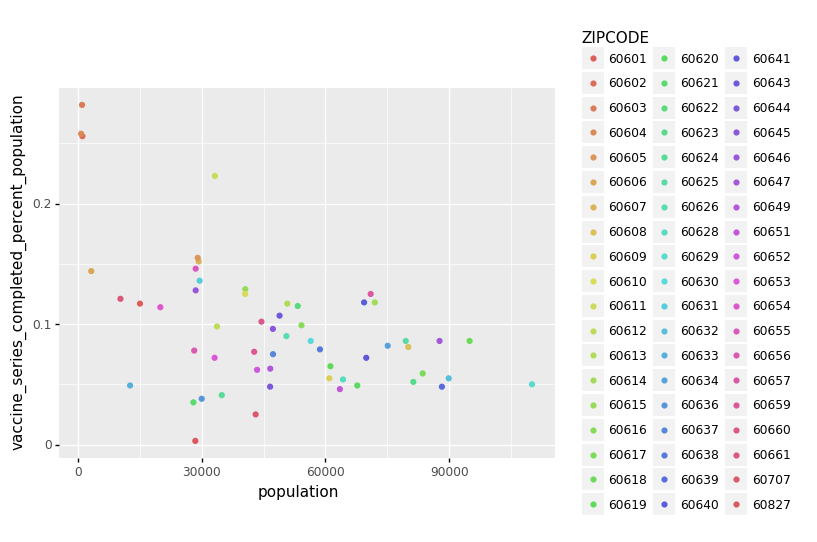

<ggplot: (8793002638074)>

In [9]:
p = ggplot(aes(x='population', y='vaccine_series_completed_percent_population'), data)
p + geom_point()
p + geom_point(aes(color='ZIPCODE'))

Clearly there are three zipcodes that are outliers in terms of being small (population wise) and having high vaccination rates. These three zip codes are 60602, 60603, and 60604 which are all located in the Loop.

In [10]:
data[data.vaccine_series_completed_percent_population > 0.25]

,index_x,ZIPCODE,STD_DATE_x,total_doses_daily,total_doses_cumulative,vaccine_series_completed_daily,vaccine_series_completed_percent_population,population,AVG7DAY_total_doses_daily,AVG7DAY_vaccine_series_completed_daily,...,pct_black,pct_white,pct_pacific_islander,pct_american_indian,pct_other_race,pct_high_school_grad,pct_hholds_w_computer,pct_hholds_w_internet,pct_w_health_insur,state
17,2713,60602,2021-03-09 00:00:00,3,742,1,0.256,1145,9.714286,4.428571,...,4.3,59.4,0.0,6.6,0.0,0.0,100.0,89.9,98.8,17
31,2737,60604,2021-03-09 00:00:00,6,530,3,0.258,823,6.571429,3.285714,...,5.0,62.5,0.0,0.0,0.0,0.0,100.0,91.8,99.5,17
42,2723,60603,2021-03-09 00:00:00,4,787,2,0.282,1052,6.714286,3.285714,...,3.2,60.8,0.0,0.0,0.0,0.0,100.0,91.3,91.6,17


### Vaccination rate by percent white

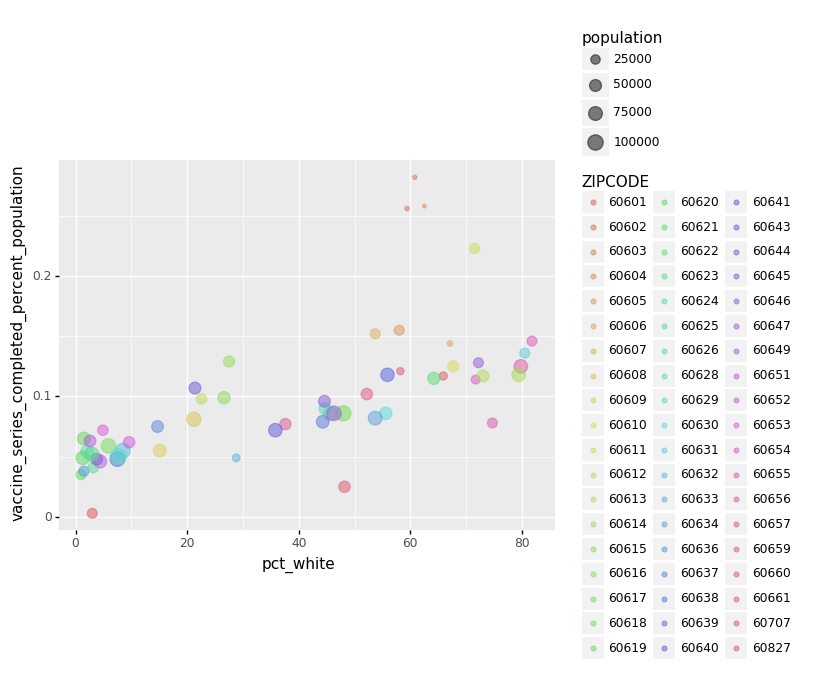

<ggplot: (8793002638059)>

In [11]:
p = ggplot(aes(x='pct_white', y='vaccine_series_completed_percent_population', size='population', color='ZIPCODE'), data)
p + geom_point(alpha=0.5)

### Vaccination rate by percent black

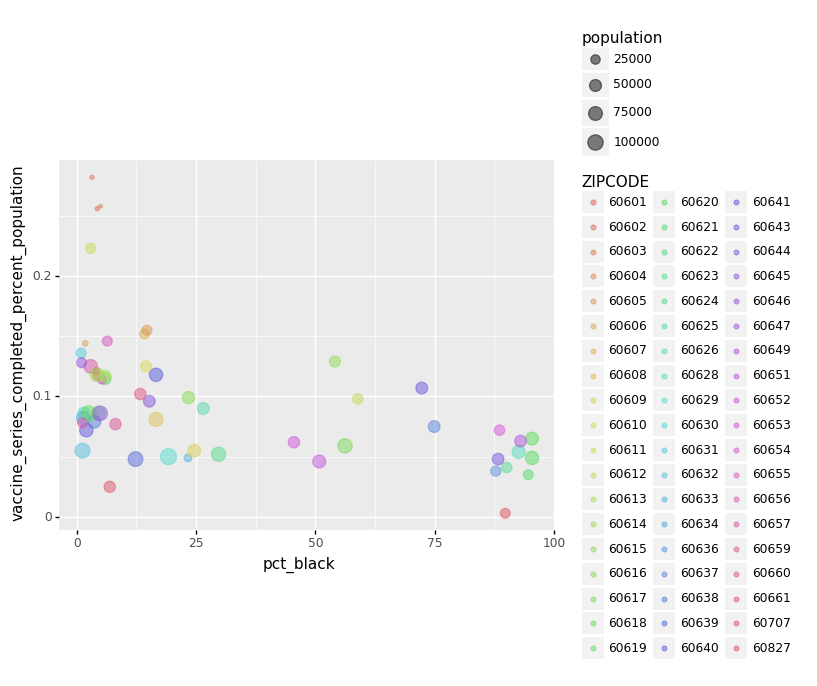

<ggplot: (8793004050682)>

In [12]:
p = ggplot(aes(x='pct_black', y='vaccine_series_completed_percent_population', size='population', color='ZIPCODE'), data)
p + geom_point(alpha=0.5)

### Vaccination rate by internet access

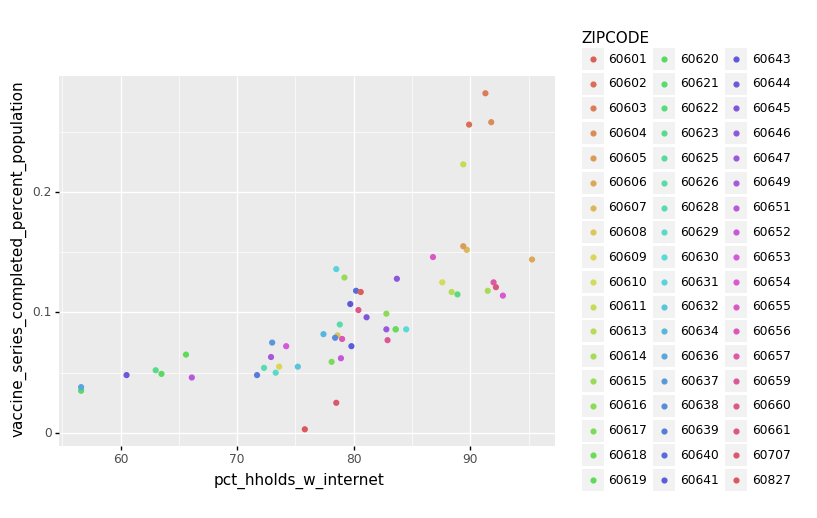

<ggplot: (8793002801137)>

In [13]:
p = ggplot(aes(x='pct_hholds_w_internet', y='vaccine_series_completed_percent_population'), data[data.AVG7DAY_RESTAURANT < 200])
p + geom_point()
p + geom_point(aes(color='ZIPCODE'))

While we cannot draw any firm conclusions from these plots, there does appear to be some evidence of correlation between the vaccination rate of a community and certain demographic variables. The most salient relationships appear to be with race and internet access (which is likely a proxy for income).

### Does vaccination rate predict higher foot traffic?

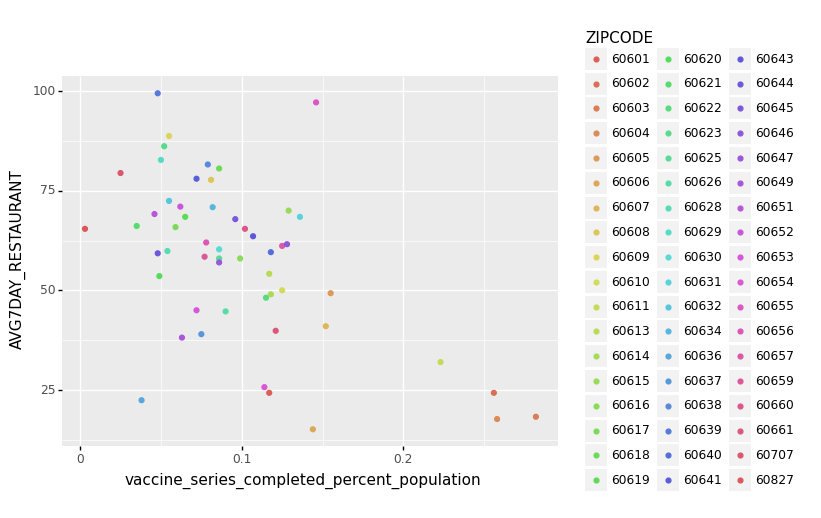

<ggplot: (8793003241933)>

In [14]:
p = ggplot(aes(x='vaccine_series_completed_percent_population', y='AVG7DAY_RESTAURANT'), data[data.AVG7DAY_RESTAURANT < 200])
p + geom_point()
p + geom_point(aes(color='ZIPCODE'))


This plot indicates a negative association between foot traffic (specifically in restaurants) and vaccination rate. Further analysis could be done to see if there is any association between recent changes in foot traffic/activity and vaccination rate.